In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [2]:
roi_file_paths = {
                'roi_1':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/segmentations/nuclei_20240604_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/exports'
                           },
                'roi_2':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/segmentations/nuclei_20240529_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports'
                           },
                'roi_3':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/segmentations/nuclei_20240604_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/exports'
                           },
                'timezero_roi_1':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/segmentations/segmentation_20240513_nuclei.tiff',
                              # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                              'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/transcripts/20240517_segmentation_withRefid.csv',
                              'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/exports'
                              },
                  'timezero_roi_2':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/segmentations/segment_091924_nuclei.tiff',
                            # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                            'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/transcripts/transcripts.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/exports'
                            },
                    'timezero_roi_3':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/segmentations/segment_20240921_nuclei.tiff',
                              # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                              'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/transcripts/transcripts.csv',
                              'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/exports'
                              },
                'run2_roi_2':{'segmentation_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/segmentation.tiff',
                            'spots_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/transcripts.csv',
                            'out_path':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/',
                            },
                'run2_roi_3':{'segmentation_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/segmentation.tiff',
                            'spots_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/transcripts.csv',
                            'out_path':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/',
                            },
                  
                  }

In [3]:
## load data for the roi of interest    
roi_of_interest = 'roi_2'

# load the sg_object
with open(f'{roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')



In [4]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [5]:
df['cell_id'] = [str(id) for id in df['object_id']]

# sg_obj.gdf['cell_id'] = [str(x) for x in sg_obj.gdf['object_id']]
sg_obj.gdf['cell_id'] = sg_obj.gdf['object_id'].astype('string')
sg_obj.gdf = sg_obj.gdf.sort_values('object_id')

# assign clusters to the sg_obj
sg_obj.gdf = sg_obj.gdf.merge(df[['cell_id']+list(df.columns.difference(sg_obj.gdf.columns))],on=['cell_id'],how='left')

In [6]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','object_id','area','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

adata_genes = sc.AnnData(df[gene_cols])

obs_cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes'] + cols_to_keep 

adata_genes.obs = df[obs_cols]

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_13429/1474621922.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes = sc.AnnData(df[gene_cols])
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [7]:
adata_genes.obs.index = [str(x) for x in adata_genes.obs.index]

In [8]:
adata_genes.obs

cell_id  n_called_barcodes barcode_names called_barcodes  object_id  \
0           1                  0           NaN              []          1   
1           2                  0           NaN              []          2   
2           3                  1        bc_060      ['bc_060']          3   
3           4                  0           NaN              []          4   
4           7                  0           NaN              []          7   
...       ...                ...           ...             ...        ...   
67197   67193                  0           NaN              []      67193   
67198   67199                  0           NaN              []      67199   
67199   67200                  0           NaN              []      67200   
67200   67201                  0           NaN              []      67201   
67201   67202                  0           NaN              []      67202   

       bc_cluster  bc_cluster_n_bcs bc_cluster_found_bcs bc_cluster_bc_names  
0             NaN               NaN                  NaN                 NaN  
1             NaN               NaN                  NaN                 NaN  
2             NaN               NaN                  NaN                 NaN  
3             NaN               NaN                  NaN                 NaN  
4             NaN               NaN                  NaN                 NaN  
...           ...               ...                  ...                 ...  
67197         NaN               NaN                  NaN                 NaN  
67198         NaN               NaN                  NaN                 NaN  
67199         NaN               NaN                  NaN                 NaN  
67200         NaN               NaN                  NaN                 NaN  
67201         NaN               NaN                  NaN                 NaN  

[67202 rows x 9 columns]

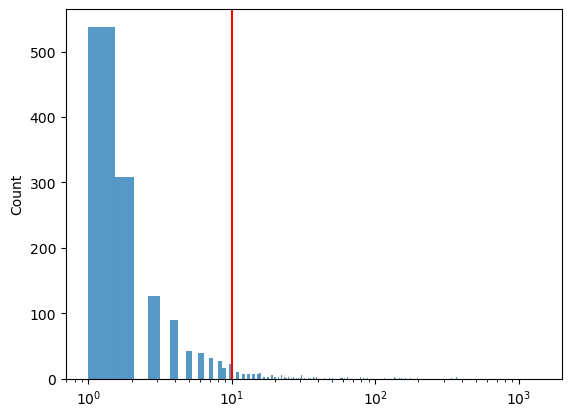

In [9]:
n_bcs_per_cluster_cutoff = 3
# n_cells_per_cluster_cutoff = 5
n_cells_per_cluster_cutoff = 10

# using the clustering to call clones
confident_clusters = adata_genes[adata_genes.obs['bc_cluster_n_bcs'] >= n_bcs_per_cluster_cutoff]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)
sns.histplot(cluster_sizes)
plt.axvline(n_cells_per_cluster_cutoff,color='r')
plt.xscale('log')

# large enough clusters
large_clusters = cluster_names[cluster_sizes >= n_cells_per_cluster_cutoff]

confident_clusters = adata_genes[adata_genes.obs['bc_cluster'].isin(large_clusters)]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)
# sns.histplot(cluster_sizes)


In [10]:
### Functions to calculate gene expression statistics by groupings

# calculate the average of each gene in each group (e.g. spatial location or clone )
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64)).tolist()

    return out

# calculate the difference between maximum and minimum for each group from grouped_obs_mean
def group_delta_mean(adata, group_key, layer=None, gene_symbols=None):
    mean = grouped_obs_mean(adata, group_key, layer=layer, gene_symbols=gene_symbols)
    delta = mean.max(axis=1) - mean.min(axis=1)
    return delta

# perform permutations on the group identities and return the distribution of deltas for each gene
def permuted_group_delta_means(adata,group_key,n_perms=100, layer=None, gene_symbols=None):
    
    perms = []
    for perm in range(n_perms):
        permuted_clusters = adata.copy()
        permuted_clusters.obs[group_key] = np.random.permutation(adata.obs[group_key].values)
        gene_by_bc_cluster_mean_perm = group_delta_mean(permuted_clusters,group_key)
        perms.append(gene_by_bc_cluster_mean_perm)

    return perms

# calculate the empirical p-values for each gene
def calculate_empirical_p_values(real_values,permuted_values):
    p_values = []
    for gene in real_values.index:
        p_values.append((np.sum(permuted_values[gene] >= real_values[gene])+1)/(len(permuted_values[gene])+1))
        
    return pd.Series(p_values,index=real_values.index)

# calculate the score for each gene, which is the ratio of the real value to the mean of the permuted values
def calculate_group_scores(real_values,permuted_values):
    return real_values/np.mean(permuted_values,axis=0)



In [11]:
# calculate the statistics for clones
real_delta  = group_delta_mean(confident_clusters,'bc_cluster')
perm_deltas = permuted_group_delta_means(confident_clusters,'bc_cluster',n_perms=1000)

# calculate the scores and p-values for the clones
scores = calculate_group_scores(real_delta,pd.DataFrame(perm_deltas))
p_vals = calculate_empirical_p_values(real_delta,pd.DataFrame(perm_deltas))

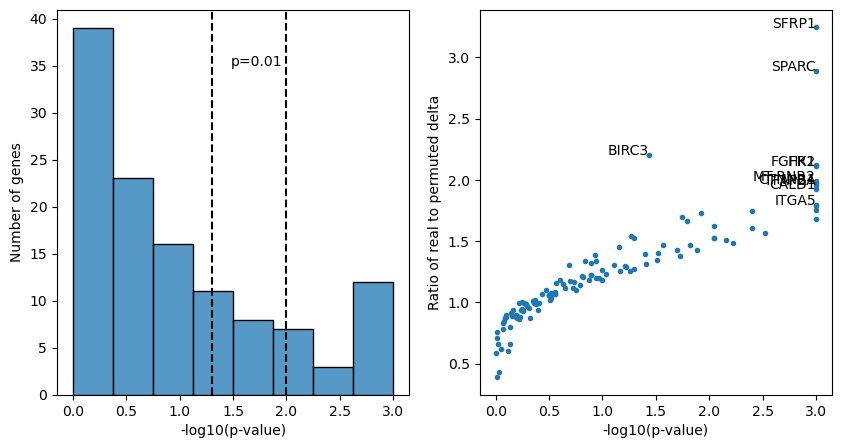

In [12]:
# plot clone scores and p-values

plt.figure(figsize=(10,5))

## subplot 
plt.subplot(1,2,1)
sns.histplot(-np.log10(p_vals))

plt.axvline(-np.log10(0.01),color='k',linestyle='--')
plt.text(-np.log10(0.01+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.05),color='k',linestyle='--')
# plt.axvline(-np.log10(0.1),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Number of genes')

# calculate ratio of real data to average from the permutations
plt.subplot(1,2,2)
plt.scatter(-np.log10(p_vals),scores,marker='.')

plt.xlabel('-log10(p-value)')
plt.ylabel('Ratio of real to permuted delta')

# annotate top genes
for gene in scores.sort_values(ascending=False)[:10].index:
    plt.text(-np.log10(p_vals[gene]),scores[gene],gene,ha='right')

In [13]:
ring_annotated = pd.read_csv('/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/data/processed_data/ring_anotated_cell_by_gene.csv',index_col=0)

adata_genes_ring = sc.AnnData(ring_annotated[[col for col in ring_annotated.columns if col in gene_cols]])

# assign erosion ring to each cell in obs according to the ring_annoted file
adata_genes_ring.obs['erosion_ring'] = ring_annotated['Erosion_Ring'].values

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_13429/3926561252.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes_ring = sc.AnnData(ring_annotated[[col for col in ring_annotated.columns if col in gene_cols]])
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
# calculate the statistics for clones
real_delta_ring  = group_delta_mean(adata_genes_ring,'erosion_ring')
perm_deltas_ring = permuted_group_delta_means(adata_genes_ring,'erosion_ring',n_perms=1000)

# calculate the scores and p-values for the clones
scores_ring = calculate_group_scores(real_delta_ring,pd.DataFrame(perm_deltas_ring))
p_vals_ring = calculate_empirical_p_values(real_delta_ring,pd.DataFrame(perm_deltas_ring))

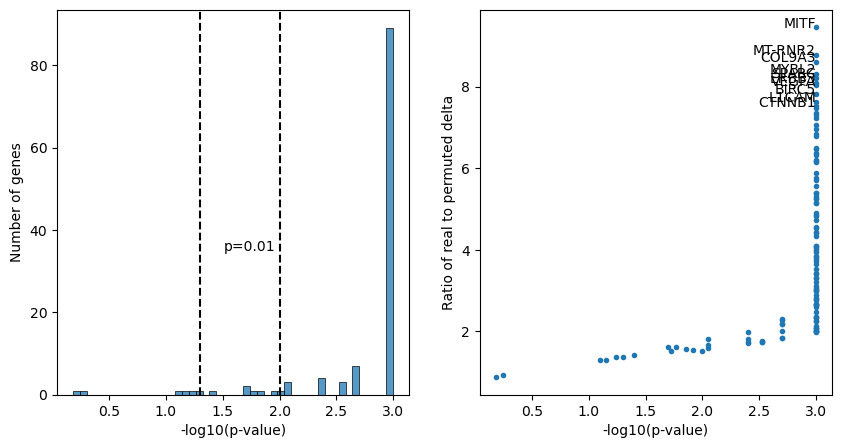

In [15]:
# plot ring scores and p-values

plt.figure(figsize=(10,5))

## subplot 
plt.subplot(1,2,1)
sns.histplot(-np.log10(p_vals_ring))

plt.axvline(-np.log10(0.01),color='k',linestyle='--')
plt.text(-np.log10(0.01+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.05),color='k',linestyle='--')
# plt.axvline(-np.log10(0.1),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Number of genes')

# calculate ratio of real data to average from the permutations
plt.subplot(1,2,2)
plt.scatter(-np.log10(p_vals_ring),scores_ring,marker='.')

plt.xlabel('-log10(p-value)')
plt.ylabel('Ratio of real to permuted delta')

# annotate top genes
for gene in scores_ring.sort_values(ascending=False)[:10].index:
    plt.text(-np.log10(p_vals_ring[gene]),scores_ring[gene],gene,ha='right')

In [134]:
scores.sort_values(ascending=True)[:10].index

Index(['IFIT2', 'MMP1', 'BMP2', 'OASL', 'CDKN1A', 'NANOG',
       'ENSMUSG00000071361', 'ITGA8', 'LMOD1', 'BMP4'],
      dtype='object')

In [135]:
scores_ring.sort_values(ascending=True)[:10].index

Index(['MMP1', 'ENSMUSG00000071361', 'MMP11', 'ITGA8', 'NOTCH3', 'VGF',
       'LMOD1', 'BMP2', 'SFRP4', 'NRG1'],
      dtype='object')

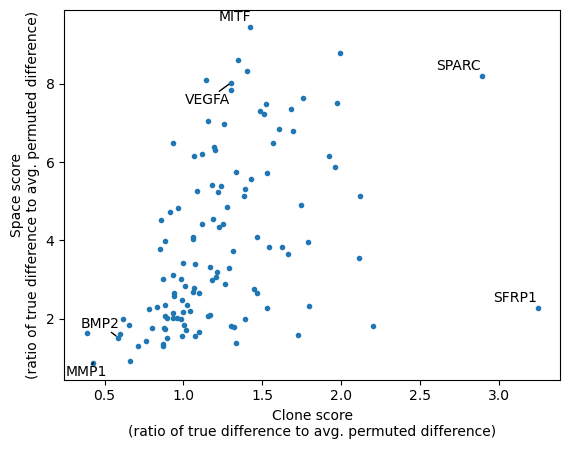

In [143]:
# plot ratio for clone and rings, only plotting genes present in both sets
common_genes = [gene for gene in scores_ring.index if gene in scores.index]

plt.scatter(scores[common_genes],scores_ring[common_genes],marker='.')
plt.xlabel('Clone score\n(ratio of true difference to avg. permuted difference)')
plt.ylabel('Space score\n(ratio of true difference to avg. permuted difference)')

# annotate top 5 genes for each using adjust_text

genes_to_plot = ['VEGFA','SFRP1','MITF','SPARC','ITGA8','MMP11']
genes_to_plot = ['VEGFA','SFRP1','MITF','SPARC','MMP1','BMP2']

texts = []

for gene in genes_to_plot:
    texts.append(plt.text(scores[gene],scores_ring[gene],gene,ha='right'))
# for gene in scores_ring.sort_values(ascending=False)[:5].index:
#     texts.append(plt.text(scores[gene],scores_ring[gene],gene,ha='right'))

# for gene in scores.sort_values(ascending=False)[:10].index:
#     if gene not in scores_ring.sort_values(ascending=False)[:10].index:
#         texts.append(plt.text(scores[gene],scores_ring[gene],gene,ha='right'))

# for gene in scores.sort_values(ascending=True)[:10].index:
#     if gene in scores_ring.sort_values(ascending=True)[:10].index:
#         if gene != 'ENSMUSG00000071361':
#             texts.append(plt.text(scores[gene],scores_ring[gene],gene,ha='right'))

adjust_text(texts,x=scores,y=scores_ring,force_static=(2,2),arrowprops=dict(arrowstyle='-',color='k'))

plt.savefig('plots/figures/clone_v_ring_scores.pdf',bbox_inches='tight')


NameError: name 'moving_average' is not defined

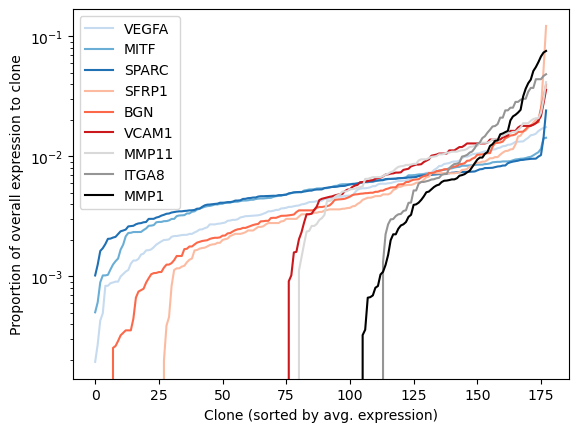

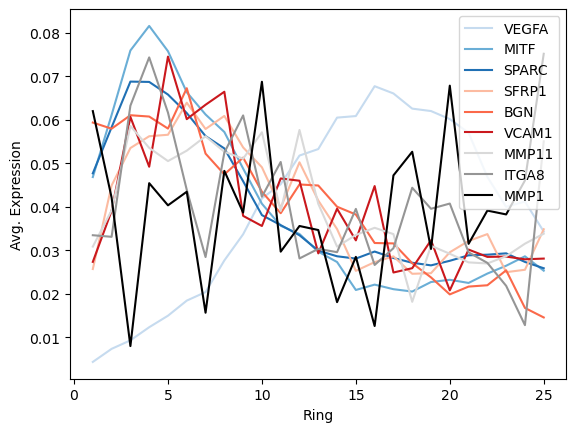

<Figure size 640x480 with 0 Axes>

In [17]:
means =grouped_obs_mean(confident_clusters,'bc_cluster')

genes_to_show = ['VEGFA',
                 'MITF',
                 'SPARC',
                 'SFRP1',
                 'BGN',
                 'VCAM1',
                 'MMP11',
                 'ITGA8',
                 'MMP1'
                 ]

colors = {'VEGFA':sns.color_palette('Blues',3)[0],
          'MITF':sns.color_palette('Blues',3)[1],
          'SPARC':sns.color_palette('Blues',3)[2],
          'SFRP1':sns.color_palette('Reds',3)[0],
          'BGN':sns.color_palette('Reds',3)[1],
        #   'SFRP4':sns.color_palette('Reds',3)[2],
        'VCAM1':sns.color_palette('Reds',3)[2],
          'MMP11':sns.color_palette('Greys',3)[0],
          'ITGA8':sns.color_palette('Greys',3)[1],
          'MMP1':'k'
          }

for gene in genes_to_show:
    plt.plot(sorted(means.loc[gene])/np.sum(means.loc[gene]),label=gene,color=colors[gene])

plt.xlabel('Clone (sorted by avg. expression)')
plt.ylabel('Proportion of overall expression to clone')
plt.yscale('log')
plt.legend()

plt.figure()
means_ring = grouped_obs_mean(adata_genes_ring,'erosion_ring')
for gene in genes_to_show:
    # plt.plot(means_ring.loc[gene],label=gene,color=colors[gene])
    plt.plot(means_ring.loc[gene]/np.sum(means_ring.loc[gene]),label=gene,color=colors[gene])

plt.legend()
plt.xlabel('Ring')
plt.ylabel('Avg. Expression')

plt.figure()
means_ring = grouped_obs_mean(adata_genes_ring,'erosion_ring')
for gene in genes_to_show:
    # plt.plot(means_ring.loc[gene],label=gene,color=colors[gene])
    plt.plot(moving_average(means_ring.loc[gene]/np.sum(means_ring.loc[gene]),3),label=gene,color=colors[gene])

plt.legend()
plt.xlabel('Ring')
plt.ylabel('Avg. Expression')




In [18]:
clone_means = grouped_obs_mean(confident_clusters,'bc_cluster')

In [20]:
gene_of_interest = 'SFRP1'


ix = np.argsort(clone_means.loc[[gene_of_interest]].values)[0][::-1]

clone_means.loc[[gene_of_interest]].values[:,ix[:5]]

clone_means.loc[[gene_of_interest]].columns[ix[:5]]

Float64Index([31.0, 490.0, 41.0, 1136.0, 391.0], dtype='float64')

In [21]:
merged_gdf = sg_obj.gdf

Cluster: 31.0 Number of cells: 58 List of cell ids: ['28140', '28279', '28729', '30256', '30446', '30561', '30762', '30823', '30807', '31023', '31084', '31076', '31476', '31595', '31648', '31749', '31632', '31665', '31816', '31860', '32300', '32342', '32452', '32534', '32536', '32578', '32852', '32881', '32762', '32817', '32873', '32960', '33102', '33160', '33206', '33174', '33204', '33256', '33239', '33406', '33482', '33565', '33547', '33515', '33599', '33669', '33640', '33642', '33629', '33780', '33911', '33871', '33990', '34141', '34203', '34375', '34772', '36023']
['bc_001' 'bc_003' 'bc_004' 'bc_006' 'bc_007' 'bc_008' 'bc_009' 'bc_010'
 'bc_014' 'bc_016' 'bc_022' 'bc_024' 'bc_025' 'bc_027' 'bc_029' 'bc_031'
 'bc_032' 'bc_033' 'bc_035' 'bc_039' 'bc_040' 'bc_041' 'bc_043' 'bc_044'
 'bc_048' 'bc_052' 'bc_056' 'bc_057' 'bc_059' 'bc_060' 'bc_063' 'bc_064'
 'bc_065' 'bc_066' 'bc_067' 'bc_068' 'bc_073' 'bc_076' 'bc_077' 'bc_080'
 'bc_081' 'bc_082' 'bc_084' 'bc_085' 'bc_087' 'bc_091' 'bc_0

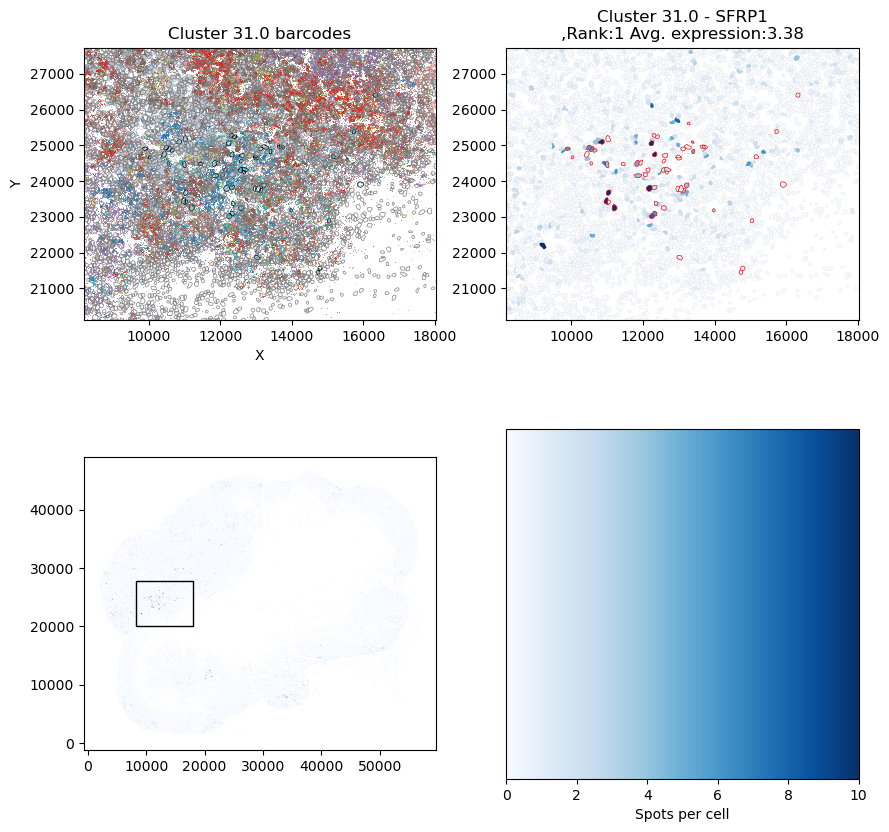

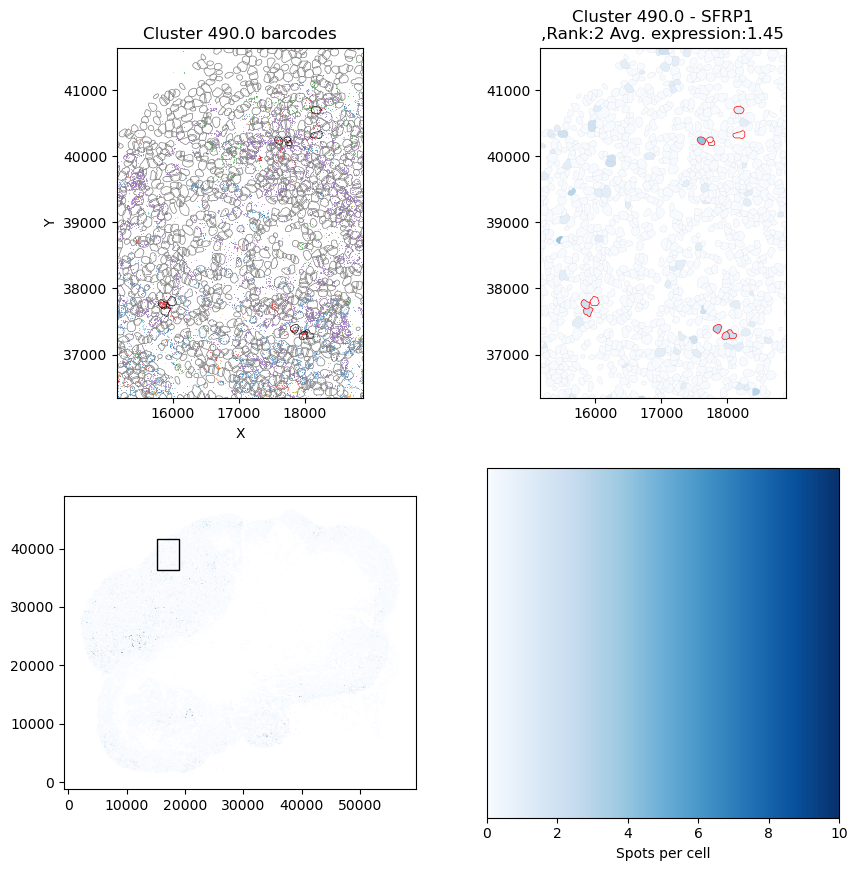

In [22]:

# gene_of_interest = 'VCAM1'
gene_of_interest = 'SFRP1'
# gene_of_interest = 'SPARC'
# gene_of_interest = 'SFRP1'
# gene_of_interest = 'FN1'
# gene_of_interest = 'BGN'

top_to_plot = 2

# get the ordering of clusters by mean expression of gene of interest
ix = np.argsort(clone_means.loc[[gene_of_interest]].values)[0][::-1]

clusters_of_interest = clone_means.loc[[gene_of_interest]].columns[ix[:top_to_plot]]
means_of_interest = clone_means.loc[[gene_of_interest]].values[:,ix[:top_to_plot]]

for rank,(cluster_of_interest,cluster_mean) in enumerate(zip(clusters_of_interest,means_of_interest[0])): 

    cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)
    print('Cluster:',cluster_of_interest,
          'Number of cells:',len(cluster_cells),
          'List of cell ids:',cluster_cells)

    central_ix = int(len(cluster_cells)/2)

    cell_id = cluster_cells[central_ix]

    region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

    # sg_obj.gdf['object_id'] = sg_obj.gdf.index
    # sg_obj.gdf['cell_id'] = sg_obj.gdf['cell_id'].astype('string')


    gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')

    print(np.unique(gene_names))

    fig = plt.figure(figsize=(10,10))

    vmin = 0
    # vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])
    vmax = max([df[gene_of_interest].quantile(0.99),10])

    ax = fig.add_subplot(221)
    tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
                                #    id_field='cell_id',
                                annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
                                focal_outline_color='k',other_outline_color='gray',
                                interior_marker='.',single_mode=False,lw=0.5,
                                exterior_marker='.',marker_size=1,ax=ax)

    plt.title(f'Cluster {cluster_of_interest} barcodes')

    ymin,ymax = plt.ylim()
    xmin,xmax = plt.xlim()

    ax = fig.add_subplot(223)

    merged_gdf.plot(column=gene_of_interest, cmap='Blues', legend=False,vmin=vmin,vmax=vmax,ax=ax)

    rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    ax = fig.add_subplot(224)

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
    cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Blues',
                                norm=norm,
                                orientation='horizontal')
    cb1.set_label('Spots per cell')
    
    ax = fig.add_subplot(222)

    gene_names = [gene_of_interest]

    # gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

    # tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
    #                             annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
    #                             focal_outline_color='r',other_outline_color='gray',
    #                             interior_marker='.',single_mode=False,lw=0.5,
    #                             exterior_marker='.',marker_size=2,ax=ax)

    plt.title(f'Cluster {cluster_of_interest} - {gene_of_interest}\n,Rank:{rank+1} Avg. expression:{cluster_mean:.2f}')

    # vmin = 0
    # vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])
    # vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),10])
    print('VRange',vmin,vmax)

    # other_clusters = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

    bbox = box(xmin,ymin,xmax,ymax)

    other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

    merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

    # print(merged_gdf_focal.shape)

    merged_gdf_other.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]

    merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]
    
    # print(merged_gdf_focal.shape)
    merged_gdf_focal.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5)

    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)

    plt.savefig(f'plots/figures/cluster_intrinsic_expression_{gene_of_interest}_{cluster_of_interest}.pdf',bbox_inches='tight')
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

Cluster: 31 Number of cells: 58 List of cell ids: ['28140', '28279', '28729', '30256', '30446', '30561', '30762', '30823', '30807', '31023', '31084', '31076', '31476', '31595', '31648', '31749', '31632', '31665', '31816', '31860', '32300', '32342', '32452', '32534', '32536', '32578', '32852', '32881', '32762', '32817', '32873', '32960', '33102', '33160', '33206', '33174', '33204', '33256', '33239', '33406', '33482', '33565', '33547', '33515', '33599', '33669', '33640', '33642', '33629', '33780', '33911', '33871', '33990', '34141', '34203', '34375', '34772', '36023']
['bc_001' 'bc_003' 'bc_004' 'bc_005' 'bc_006' 'bc_007' 'bc_008' 'bc_009'
 'bc_010' 'bc_011' 'bc_014' 'bc_016' 'bc_019' 'bc_022' 'bc_024' 'bc_025'
 'bc_027' 'bc_029' 'bc_030' 'bc_031' 'bc_032' 'bc_033' 'bc_035' 'bc_037'
 'bc_039' 'bc_040' 'bc_041' 'bc_043' 'bc_044' 'bc_045' 'bc_047' 'bc_048'
 'bc_052' 'bc_056' 'bc_057' 'bc_059' 'bc_060' 'bc_063' 'bc_064' 'bc_065'
 'bc_066' 'bc_067' 'bc_068' 'bc_073' 'bc_074' 'bc_076' 'bc_077

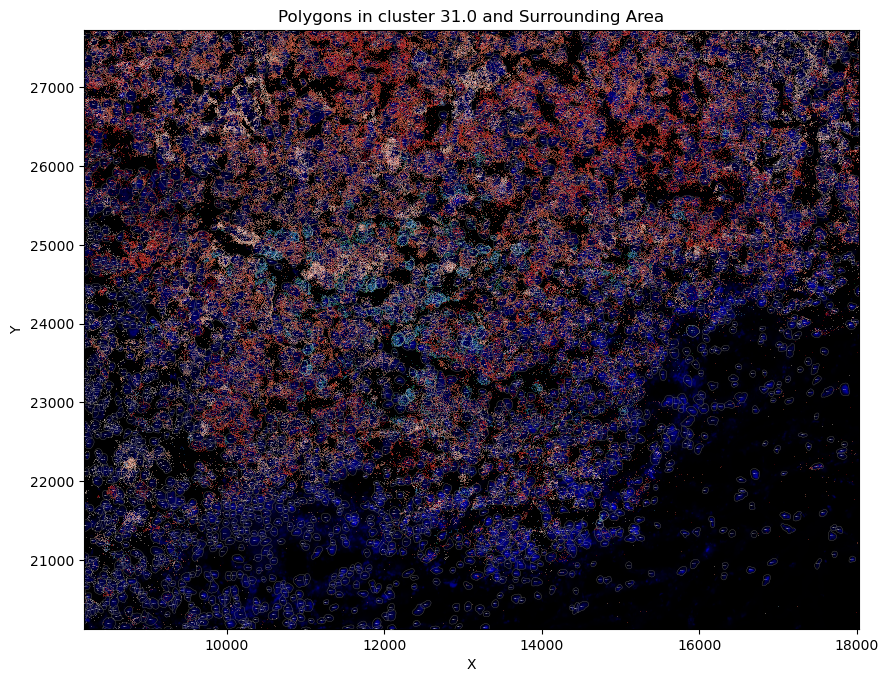

In [23]:
## cluster 31 is the one with highest SFRP1 expression.
## By eye, some cells seem to be missing from this cluster. We can manually add them.

cluster_of_interest = 31
gene_of_interest = 'SFRP1'

cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)
print('Cluster:',cluster_of_interest,
        'Number of cells:',len(cluster_cells),
        'List of cell ids:',cluster_cells)

central_ix = int(len(cluster_cells)/2)

cell_id = cluster_cells[central_ix]

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=50,id_field='cell_id')

# sg_obj.gdf['object_id'] = sg_obj.gdf.index
# sg_obj.gdf['cell_id'] = sg_obj.gdf['cell_id'].astype('string')


gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')

cluster_gene_names = literal_eval(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['bc_cluster_found_bcs'].values[0])

bc_colors = list(sns.color_palette('Greens',3)[1:3]) + list(sns.color_palette('Blues',4)[1:4])
gene_color_map = {}
for b,bc in enumerate(cluster_gene_names):
    gene_color_map[bc] = bc_colors[b]

for b,bc in enumerate(gene_names):
    if bc not in gene_color_map.keys():
        gene_color_map[bc] = sns.color_palette('Reds',10)[b%10]
    # gene_color_map[bc] = bc_colors[b]

# bc_colors = list(sns.color_palette('Set2'))
# bc_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00']
# gene_color_map = {}
# for b,bc in enumerate(cluster_gene_names):
#     gene_color_map[bc] = bc_colors[b]

# gene_color_map = {
#     'bc_040': '#a6cee3',
#     'bc_092': '#1f78b4',
#     'bc_093': '#fb9a99',
#     'bc_016': '#33a02c',
#     'bc_052': '#fdbf6f',
# }

print(np.unique(gene_names))
''
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

vmin = 0
# vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])
vmax = max([df[gene_of_interest].quantile(0.99),10])

# ax = fig.add_subplot(221)

tools.plot_polygons_and_points(sg_obj,cluster_cells,central_polygon_ix=central_ix,
                               gene_names=gene_names, # show all barcodes in the area
                               color_map=gene_color_map,
                            #    gene_names=cluster_gene_names, # show only barocdes in the cluster of interest
                            #    color_map=gene_color_map,
                            #    id_field='cell_id',
                            annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
                            other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.2,
                            exterior_marker='.',marker_size=0.5,ax=ax,
                            # focal_outline_color='k',
                            focal_outline_color='w',
                            show_image=True,
                            image_path='/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/2024-05-21_spatialbarcodes_tumor_expression/roi_2/hyb_1_aligned.tiff',
                            annotate_cells=True,
                            annotation_color='w',
                            annotation_fontsize=0.5)

# for b,bc in enumerate(cluster_gene_names):
#     plt.text(0.99,0.0+b*0.02,bc,color=gene_color_map[bc],transform=ax.transAxes,ha='right')

# plt.savefig(f'plots/figures/cluster_{cluster_of_interest}_bcs_annotated_image.pdf',bbox_inches='tight')
plt.savefig(f'plots/figures/cluster_{cluster_of_interest}_bcs_annotated_HotCold_image.pdf',bbox_inches='tight')


In [24]:
cols_here = ['object_id','bc_cluster','bc_cluster_bc_names','called_barcodes']+cluster_gene_names 

df_region = region[cols_here]

df_region['cluster_bc_count'] = df_region[cluster_gene_names].sum(axis=1)
df_region['nonzero_cluster_bc_count'] = df_region[cluster_gene_names].astype(bool).sum(axis=1)

df_region[(df_region['cluster_bc_count'] > 10) & (df_region['nonzero_cluster_bc_count'] > 2)].to_csv('manual_annotation_cluster31.csv',index=False)
# df_region[~((df_region['cluster_bc_count'] > 10) & (df_region['nonzero_cluster_bc_count'] > 2)) & (df_region['bc_cluster'] == 31)].to_csv('manual_annotation_cluster31_additions.csv',index=False)


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_13429/2461751416.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_region['cluster_bc_count'] = df_region[cluster_gene_names].sum(axis=1)
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_13429/2461751416.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_region['nonzero_cluster_bc_count'] = df_region[cluster_gene_names].astype(bool).sum(axis=1)


In [25]:
# new_version = df_region[(df_region['cluster_bc_count'] > 10) & (df_region['nonzero_cluster_bc_count'] > 2)]
# new_version['object_id'] = new_version['object_id'].astype(int)

# old_version = pd.read_csv('cluster 31 manual annotation - manual annnotation.csv')
# old_version = old_version[old_version['object_id'].notnull()]

# old_version['object_id'] = old_version['object_id'].astype(int)



# pd.merge(new_version,old_version,on=list(new_version.columns),how='outer').to_csv('cluster 31 manual annotation - manual annnotation larger radius.csv',index=False)
# # pd.merge(new_version,old_version,on='object_id',how='outer').to_csv('cluster 31 manual annotation - manual annnotation sequel.csv',index=False)


In [26]:
## LOAD MANUAL ANNOTATION FILE

manual_annotation = pd.read_csv('cluster 31 manual annotation - manual_annotation_radius_large.csv')

manual_annotation= manual_annotation[manual_annotation['object_id'].notnull()]


In [27]:
manual_cluster = manual_annotation[((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['POSSIBLE','TRUE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['TRUE']))) |

                   ((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['TRUE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['POSSIBLE','TRUE']))) | 
                   
                   ((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['POSSIBLE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['POSSIBLE']))) 

                   ] 
                   

['bc_001' 'bc_004' 'bc_006' 'bc_007' 'bc_009' 'bc_010' 'bc_016' 'bc_022'
 'bc_024' 'bc_027' 'bc_029' 'bc_031' 'bc_032' 'bc_035' 'bc_039' 'bc_040'
 'bc_041' 'bc_044' 'bc_048' 'bc_052' 'bc_059' 'bc_060' 'bc_063' 'bc_064'
 'bc_065' 'bc_066' 'bc_067' 'bc_068' 'bc_076' 'bc_077' 'bc_080' 'bc_084'
 'bc_085' 'bc_087' 'bc_088' 'bc_091' 'bc_092' 'bc_093']
VRange 0 10


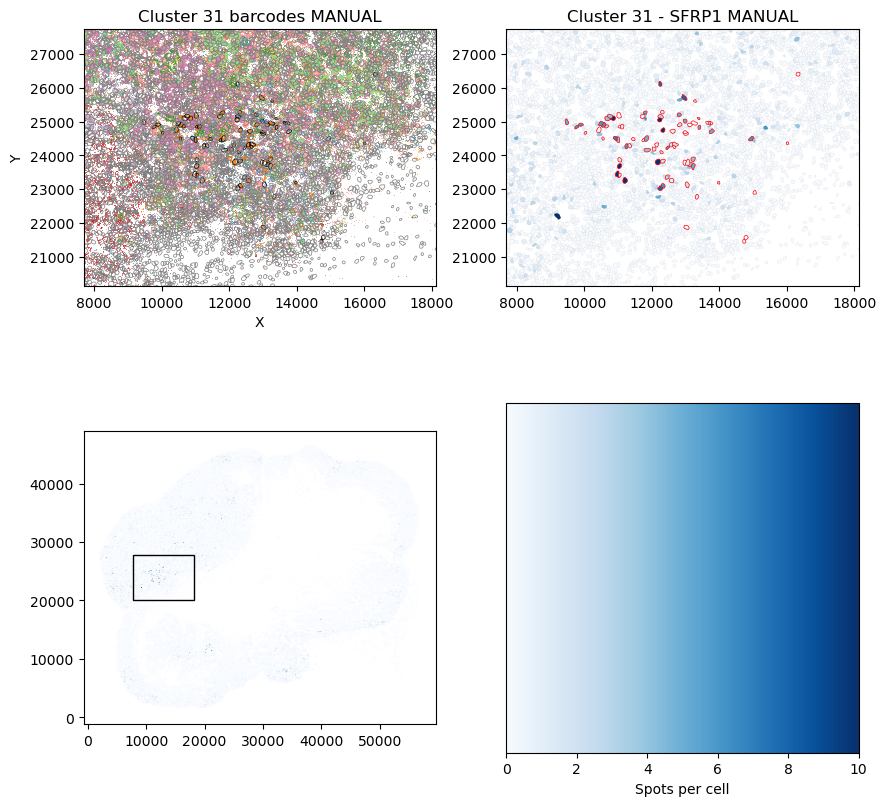

In [28]:
### plot the pattern with the cluster manually curated


# gene_of_interest = 'VCAM1'
gene_of_interest = 'SFRP1'
# gene_of_interest = 'SPARC'
# gene_of_interest = 'SFRP1'
# gene_of_interest = 'FN1'
# gene_of_interest = 'BGN'
cluster_of_interest = 31

# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)

cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)

central_ix = int(len(cluster_cells)/2)

cell_id = cluster_cells[central_ix]

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

# sg_obj.gdf['object_id'] = sg_obj.gdf.index
# sg_obj.gdf['cell_id'] = sg_obj.gdf['cell_id'].astype('string')


gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')

print(np.unique(gene_names))

fig = plt.figure(figsize=(10,10))

vmin = 0
# vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])
vmax = max([df[gene_of_interest].quantile(0.99),10])

ax = fig.add_subplot(221)
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
                            #    id_field='cell_id',
                            annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
                            focal_outline_color='k',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.5,
                            exterior_marker='.',marker_size=1,ax=ax)

plt.title(f'Cluster {cluster_of_interest} barcodes MANUAL')

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

ax = fig.add_subplot(223)

merged_gdf.plot(column=gene_of_interest, cmap='Blues', legend=False,vmin=vmin,vmax=vmax,ax=ax)

rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax = fig.add_subplot(224)

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Blues',
                            norm=norm,
                            orientation='horizontal')
cb1.set_label('Spots per cell')

ax = fig.add_subplot(222)

gene_names = [gene_of_interest]

# gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

# tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
#                             annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
#                             focal_outline_color='r',other_outline_color='gray',
#                             interior_marker='.',single_mode=False,lw=0.5,
#                             exterior_marker='.',marker_size=2,ax=ax)

plt.title(f'Cluster {cluster_of_interest} - {gene_of_interest} MANUAL')

# vmin = 0
# vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])
# vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),10])
print('VRange',vmin,vmax)

# other_clusters = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

bbox = box(xmin,ymin,xmax,ymax)

other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

# print(merged_gdf_focal.shape)

merged_gdf_other.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

# this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.savefig(f'plots/figures/cluster_intrinsic_expression_{gene_of_interest}_{cluster_of_interest}_MANUAL.pdf',bbox_inches='tight')
# sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

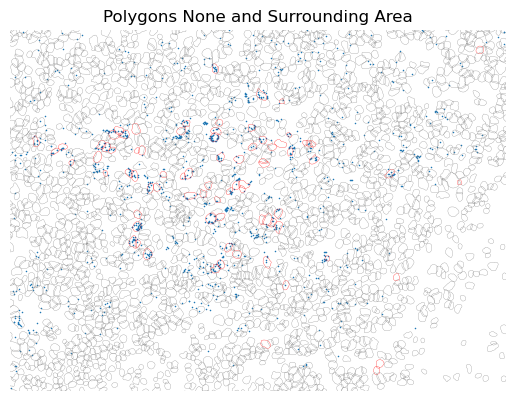

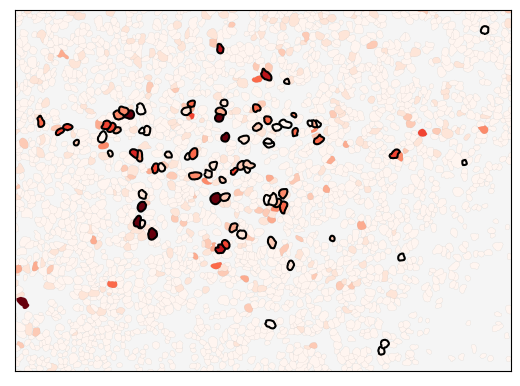

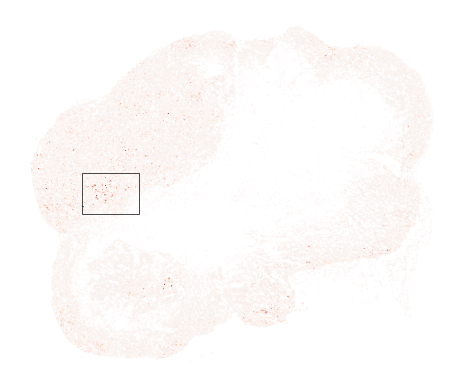

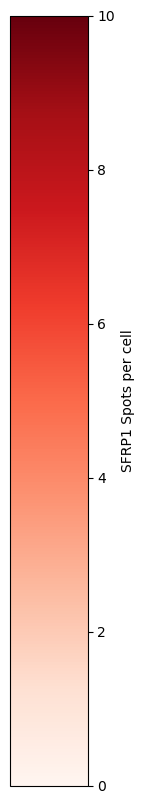

In [234]:
# gene_of_interest = 'VCAM1'
gene_of_interest = 'SFRP1'
# gene_of_interest = 'SPARC'
# gene_of_interest = 'SFRP1'
# gene_of_interest = 'FN1'
# gene_of_interest = 'BGN'
cluster_of_interest = 31

# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)

cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)

central_ix = int(len(cluster_cells)/2)

cell_id = cluster_cells[central_ix]

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

# sg_obj.gdf['object_id'] = sg_obj.gdf.index
# sg_obj.gdf['cell_id'] = sg_obj.gdf['cell_id'].astype('string')


gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')


fig,ax = plt.subplots()
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SFRP1'],central_polygon_ix=central_ix,
                            color_map={'SFRP1':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                            #    id_field='cell_id',
                            annotate=False,image_scale=0.1,
                            focal_outline_color='r',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.2,
                            exterior_marker='.',marker_size=5,ax=ax)

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

plt.axis('off')
# plt.title()

### PLOT THE ZOOMED IN IMAGE     
fig,ax = plt.subplots()

vmin = 0
vmax = 10

bbox = box(xmin,ymin,xmax,ymax)

other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

# other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

# print(merged_gdf_focal.shape)

merged_gdf_other.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

# this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='k',linewidth=1.5)

# rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
# ax.add_patch(rect)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('#F5F5F5')

plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_zoom.pdf',bbox_inches='tight')


### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
fig,ax = plt.subplots()

# ax = fig.add_subplot(223)

merged_gdf.plot(column=gene_of_interest, cmap='Reds', legend=False,vmin=vmin,vmax=vmax,ax=ax,
                edgecolor='#d9d9d9',linewidth=0.01)


# ax.set_facecolor('k')
rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

# ax.set_facecolor('#F5F5F5')
# ax.set_xticks([])
# ax.set_yticks([])
plt.axis('off')

plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_full.pdf',bbox_inches='tight')


### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(1,10))
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')



In [93]:
np.unique(df[df['object_id'].isin(manual_cluster['object_id'])]['bc_cluster'],return_counts=True)

(array([  31.,   41.,  132.,  194.,  315.,  355.,  476.,  601.,  612.,
         898., 1096., 1594., 1642., 2630., 2642.]),
 array([51,  1,  6,  5,  1,  3,  1,  1,  1,  1,  2,  1,  2,  1,  2]))

In [145]:
df['object_id']

0            1
1            2
2            3
3            4
4            7
         ...  
67197    67193
67198    67199
67199    67200
67200    67201
67201    67202
Name: object_id, Length: 67202, dtype: int64

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_13429/2893520580.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3,1,1)


Text(0.5, 0, 'Proportion of cells in group (sorted)')

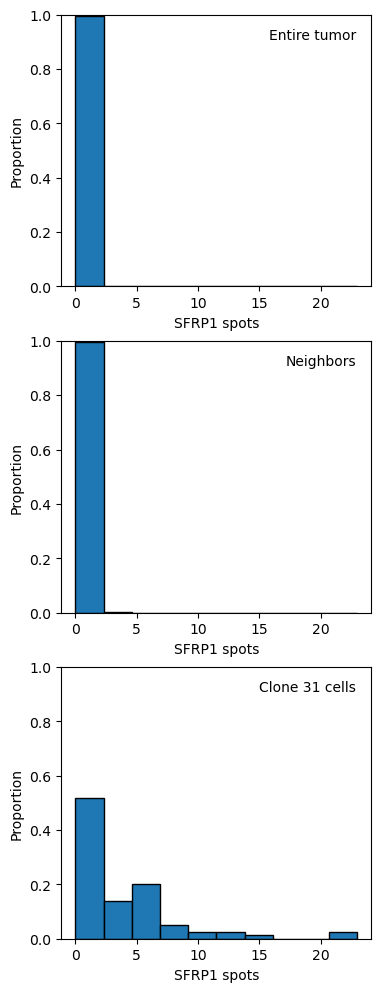

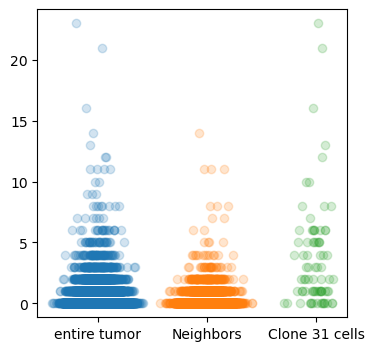

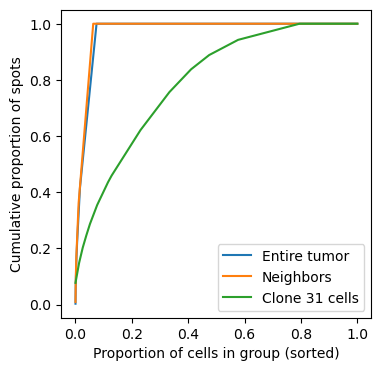

In [273]:
#### plot distributions of counts within the clone, compared to its neighborhood and the entire tumor 
plt.subplots(figsize=(4,12),sharex=True,sharey=True)
# non_zero_cells = df[df['SFRP1']>1]
counts,bins = np.histogram(df['SFRP1'])

cluster_of_interest = 31

# entire tumor
ax = plt.subplot(3,1,1)
plt.text(s='Entire tumor',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Entire tumor')
sns.histplot(df['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlabel('SFRP1 spots')
# neighbors
ax = plt.subplot(3,1,2)
plt.text(s='Neighbors',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Clone 31 neighboring cells')
sns.histplot(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlabel('SFRP1 spots')
# clone 31
ax = plt.subplot(3,1,3)
plt.text(s='Clone 31 cells',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
sns.histplot(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlabel('SFRP1 spots')
plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_hists.pdf',bbox_inches='tight')


fig,ax = plt.subplots(figsize=(4,4))

# entire tumor
ax.scatter([tools.jitter_point(0,0.1) for x in df['SFRP1']],
            df['SFRP1'],alpha=0.2)


# neighbors
neighbors = df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]
ax.scatter([tools.jitter_point(1,0.1) for x in neighbors['SFRP1']],
            neighbors['SFRP1'],alpha=0.2)

# clone 31
ax.scatter([tools.jitter_point(2,0.1) for x in df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']],
            df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],alpha=0.2)
# sns.histplot(,bins=bins,alpha=1.0,stat='proportion',ax=ax)

plt.xticks(range(3),['entire tumor','Neighbors','Clone 31 cells'])
plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_jitter.pdf',bbox_inches='tight')

fig,ax = plt.subplots(figsize=(4,4))
plt.plot(np.linspace(0,1,len(df['SFRP1'])),
         np.cumsum(df['SFRP1'].sort_values(ascending=False).values)/np.sum(df['SFRP1']),
         label='Entire tumor')
plt.plot(np.linspace(0,1,len(neighbors['SFRP1'])),
         np.cumsum(neighbors['SFRP1'].sort_values(ascending=False).values)/np.sum(neighbors['SFRP1']),
         label='Neighbors')
plt.plot(np.linspace(0,1,len(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'])),
         np.cumsum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'].sort_values(ascending=False).values)/np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']),
         label='Clone 31 cells')
plt.legend()

plt.ylabel('Cumulative proportion of spots')
plt.xlabel('Proportion of cells in group (sorted)')



3
bc_cluster
1096.0    4.000000
31.0      3.379310
612.0     3.250000
2642.0    2.571429
355.0     2.400000
            ...   
888.0     0.000000
873.0     0.000000
867.0     0.000000
864.0     0.000000
3320.0    0.000000
Name: SFRP1, Length: 551, dtype: float64
5
bc_cluster
31.0      3.379310
2642.0    2.571429
355.0     2.400000
194.0     2.125000
1160.0    1.500000
            ...   
706.0     0.000000
730.0     0.000000
737.0     0.000000
796.0     0.000000
3320.0    0.000000
Name: SFRP1, Length: 336, dtype: float64
10
bc_cluster
31.0      3.379310
490.0     1.454545
41.0      0.692308
1136.0    0.571429
391.0     0.557377
            ...   
574.0     0.000000
1169.0    0.000000
1228.0    0.000000
220.0     0.000000
406.0     0.000000
Name: SFRP1, Length: 178, dtype: float64
25
bc_cluster
31.0      3.379310
391.0     0.557377
253.0     0.529412
51.0      0.500000
415.0     0.479452
            ...   
270.0     0.031250
121.0     0.022989
369.0     0.012658
1111.0    0.010753
266.0 

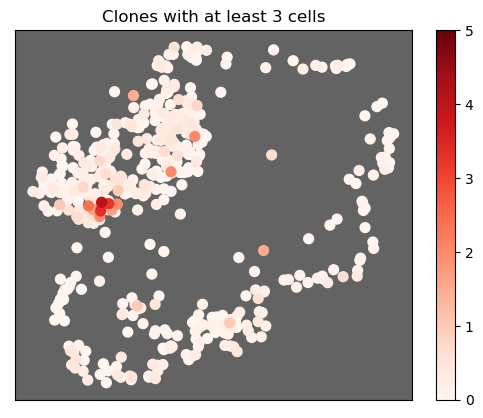

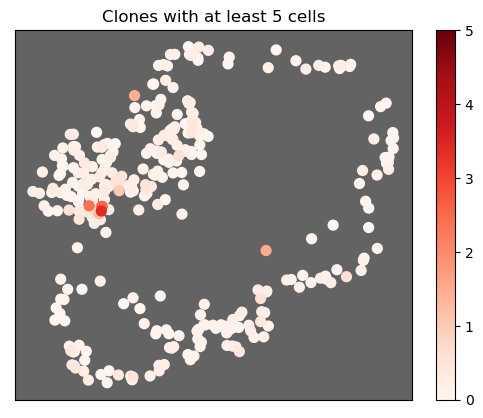

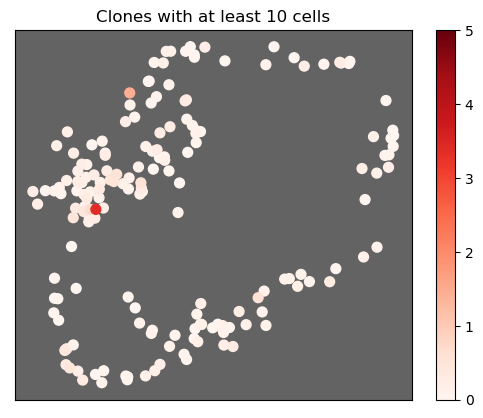

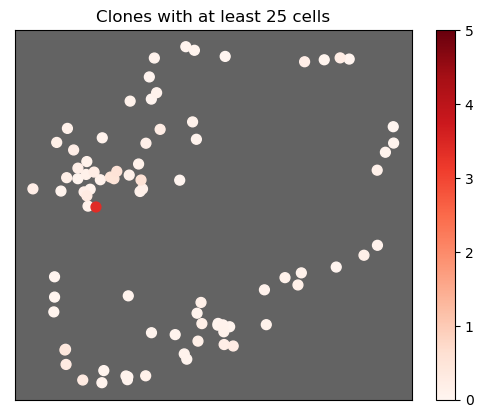

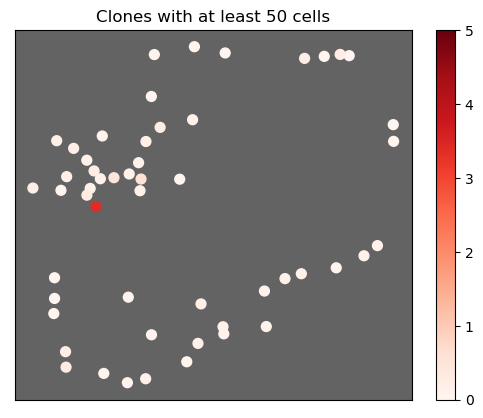

In [267]:
# plot each clone as a single point with the average expression of a particular gene
n_bcs_per_cluster_cutoff = 3
# n_cells_per_cluster_cutoff = 5

gene_of_interest = 'SFRP1'
vmin = 0
vmax = 5

# gene_of_interest = 'SPARC'
# vmin = 0
# vmax = 50

n_cells_per_cluster_cutoffs = [3,5,10,25,50]

for cutoff_here in n_cells_per_cluster_cutoffs:

    # using the clustering to call clones
    confident_clusters_here = adata_genes[adata_genes.obs['bc_cluster_n_bcs'] >= n_bcs_per_cluster_cutoff]

    cluster_names, cluster_sizes = np.unique(confident_clusters_here.obs['bc_cluster'],return_counts=True)
    # large enough clusters
    large_clusters = cluster_names[cluster_sizes >= cutoff_here]
    confident_clusters_here = adata_genes[adata_genes.obs['bc_cluster'].isin(large_clusters)]

    # sns.histplot(cluster_sizes)


    confident_cluster_list = confident_clusters_here.obs['bc_cluster'].values

    confident_clusters_gdf = sg_obj.gdf[sg_obj.gdf['bc_cluster'].isin(confident_cluster_list)]

    # print()

    # plot the centroid of each cluster, 
    # plt.figure(figsize=(10,10))
    plt.figure()
    plt.title(f'Clones with at least {cutoff_here} cells')
    # for cluster in confident_cluster_list:
    cluster_centroids = confident_clusters_gdf.dissolve(by='bc_cluster').centroid

    gene_means = confident_clusters_gdf.groupby(by='bc_cluster')[gene_of_interest].mean()
    print(cutoff_here)
    print(gene_means.sort_values(ascending=False))

    ordering = np.argsort(gene_means.values)
    plt.gca().set_facecolor('#636363')

        # centroid = confident_clusters_gdf[confident_clusters_gdf['bc_cluster']==cluster].geometry.centroid.values[-]
        # centroid = confident_clusters_gdf[confident_clusters_gdf['bc_cluster']==cluster].dissolve().centroid
    plt.scatter(cluster_centroids.x.values[ordering],cluster_centroids.y.values[ordering],
                    c=gene_means.values[ordering],
                    cmap='Reds',
                    vmin=vmin,vmax=vmax,
                    marker='o',s=50)

    plt.colorbar()

    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

    # cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
    #                         norm=norm,
    #                         orientation='vertical')
    # cb1.set_label('SFRP1 Spots per cell')


    

    # plt.savefig(f'')
# sg_obj.gdf[]

In [166]:
confident_clusters

View of AnnData object with n_obs × n_vars = 12609 × 119
    obs: 'cell_id', 'n_called_barcodes', 'barcode_names', 'called_barcodes', 'object_id', 'bc_cluster', 'bc_cluster_n_bcs', 'bc_cluster_found_bcs', 'bc_cluster_bc_names'

In [173]:
confident_cluster_list = confident_clusters.obs['bc_cluster'].values

confident_clusters_gdf = sg_obj.gdf[sg_obj.gdf['bc_cluster'].isin(confident_cluster_list)]



0    POINT (12474.422 24193.643)
dtype: geometry

In [182]:
confident_clusters_gdf[confident_clusters_gdf['bc_cluster']==31].dissolve().centroid.x

0    12474.421608
dtype: float64

In [191]:
confident_clusters_gdf.dissolve(by='bc_cluster').centroid

bc_cluster
8.0        POINT (13319.128 2599.909)
10.0      POINT (26798.530 32510.665)
15.0      POINT (18758.222 26097.772)
16.0      POINT (47302.894 42517.091)
17.0      POINT (26881.977 33985.134)
                     ...             
2161.0     POINT (30709.254 8856.949)
2386.0     POINT (16959.809 2970.805)
2472.0    POINT (45866.579 15179.231)
3176.0    POINT (11065.986 28192.587)
3294.0     POINT (22993.474 7128.711)
Length: 178, dtype: geometry

In [192]:
confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean()

bc_cluster
8.0       0.076923
10.0      0.061224
15.0      0.091371
16.0      0.244318
17.0      0.100000
            ...   
2161.0    0.101449
2386.0    0.056410
2472.0    0.285714
3176.0    0.122449
3294.0    0.100000
Name: SFRP1, Length: 178, dtype: float64

In [ ]:
confident_clusters_gdf[confident_clusters_gdf['bc_cluster']==cluster].dissolve().centroid

In [205]:
ordering 

array([  8,  99,  10, 149,  84,  56,  14,  92, 142, 154, 104,  13, 163,
        44, 102,  98,   5,  94, 175,  77,  27, 123, 134, 155,  91,  31,
       165,   3,  88, 115,  70, 111,  37,  54,  43,  97, 121, 124,  63,
       131,  83, 110,  95, 107, 166, 169, 144,  76,  55,  81,   9,  80,
        51,   7, 118,  40,  23,  16, 158,  42,  19,  20, 137, 127, 156,
       139,  41,  47,  67,  45,  82, 176,  93,  18,  74,  36, 105, 160,
        96, 173,  33,   4, 177, 157, 151, 126,  17,  24, 130, 164, 128,
        35, 145,   2, 171,  90, 114,  57,  52,  49,  78,  71,   6, 152,
        30, 132,   0, 119,  21,  58, 147, 143,  38, 168, 133, 167, 138,
        87, 162,  60, 136,  26,  86,   1, 125,  53, 174, 116, 122,  66,
       129,  32,  11, 103, 117, 159,  62,  50,  73, 146, 170,  22,  64,
        25, 112, 120,  61,  29,  79, 148,  59, 150,  28,  65,  68, 172,
       106,  89,  69, 108,  48, 101,  46,  12, 135, 161,  15, 140, 141,
        85, 153, 109,  72,  39, 113,  75,  34, 100])

3
bc_cluster
2472.0    61.642857
836.0     54.000000
1846.0    49.666667
175.0     36.357143
1333.0    34.666667
            ...    
1630.0     2.500000
162.0      2.250000
1077.0     2.200000
291.0      1.750000
864.0      1.222222
Name: SPARC, Length: 551, dtype: float64
5
bc_cluster
2472.0    61.642857
175.0     36.357143
523.0     33.833333
3320.0    32.600000
3098.0    31.000000
            ...    
1099.0     3.000000
593.0      2.800000
1306.0     2.600000
1077.0     2.200000
864.0      1.222222
Name: SPARC, Length: 336, dtype: float64
10
bc_cluster
2472.0    61.642857
175.0     36.357143
420.0     26.200000
1298.0    25.444444
741.0     24.466667
            ...    
894.0      4.750000
238.0      4.389205
574.0      4.157895
384.0      3.200000
1306.0     2.600000
Name: SPARC, Length: 178, dtype: float64
25
bc_cluster
175.0    36.357143
420.0    26.200000
475.0    24.366972
431.0    24.216216
218.0    24.096774
           ...    
225.0     6.944954
138.0     6.746032
121.0     6

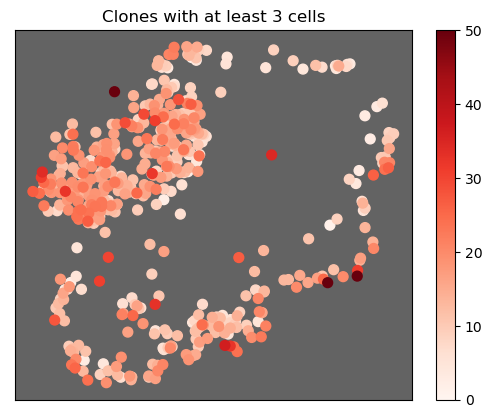

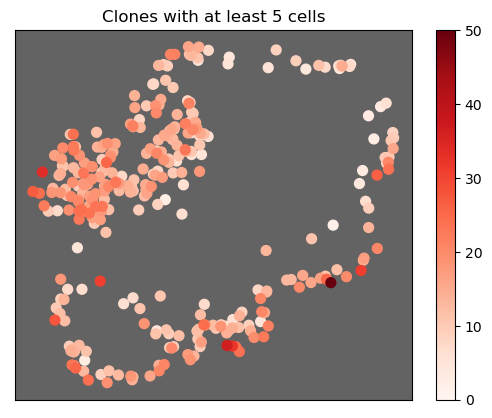

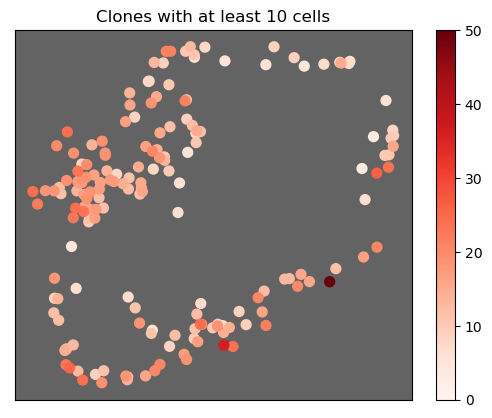

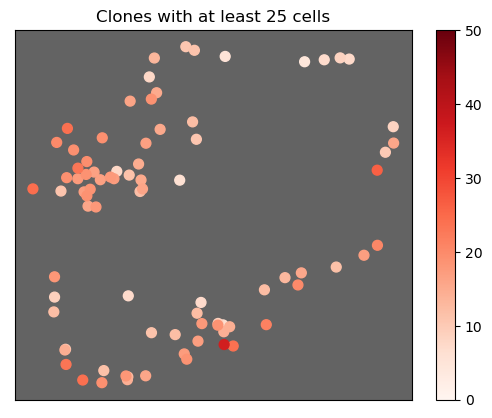

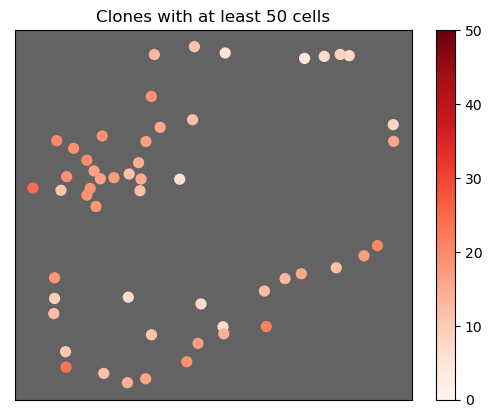

In [253]:
# plot each clone as a single point with the average expression of a particular gene
n_bcs_per_cluster_cutoff = 3
# n_cells_per_cluster_cutoff = 5

# gene_of_interest = 'SFRP1'
# vmin = 0
# vmax = 5

gene_of_interest = 'SPARC'
vmin = 0
vmax = 50

n_cells_per_cluster_cutoffs = [3,5,10,25,50]

for cutoff_here in n_cells_per_cluster_cutoffs:

    # using the clustering to call clones
    confident_clusters_here = adata_genes[adata_genes.obs['bc_cluster_n_bcs'] >= n_bcs_per_cluster_cutoff]

    cluster_names, cluster_sizes = np.unique(confident_clusters_here.obs['bc_cluster'],return_counts=True)
    # large enough clusters
    large_clusters = cluster_names[cluster_sizes >= cutoff_here]
    confident_clusters_here = adata_genes[adata_genes.obs['bc_cluster'].isin(large_clusters)]

    # sns.histplot(cluster_sizes)


    confident_cluster_list = confident_clusters_here.obs['bc_cluster'].values

    confident_clusters_gdf = sg_obj.gdf[sg_obj.gdf['bc_cluster'].isin(confident_cluster_list)]

    # print()

    # plot the centroid of each cluster, 
    # plt.figure(figsize=(10,10))
    plt.figure()
    plt.title(f'Clones with at least {cutoff_here} cells')
    # for cluster in confident_cluster_list:
    cluster_centroids = confident_clusters_gdf.dissolve(by='bc_cluster').centroid

    gene_means = confident_clusters_gdf.groupby(by='bc_cluster')[gene_of_interest].mean()
    print(cutoff_here)
    print(gene_means.sort_values(ascending=False))

    ordering = np.argsort(gene_means.values)
    plt.gca().set_facecolor('#636363')

        # centroid = confident_clusters_gdf[confident_clusters_gdf['bc_cluster']==cluster].geometry.centroid.values[-]
        # centroid = confident_clusters_gdf[confident_clusters_gdf['bc_cluster']==cluster].dissolve().centroid
    plt.scatter(cluster_centroids.x.values[ordering],cluster_centroids.y.values[ordering],
                    c=gene_means.values[ordering],
                    cmap='Reds',
                    vmin=vmin,vmax=vmax,
                    marker='o',s=50)

    plt.colorbar()

    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

    # cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
    #                         norm=norm,
    #                         orientation='vertical')
    # cb1.set_label('SFRP1 Spots per cell')


    

    # plt.savefig(f'')
# sg_obj.gdf[]

['bc_001' 'bc_004' 'bc_008' 'bc_014' 'bc_016' 'bc_022' 'bc_024' 'bc_027'
 'bc_028' 'bc_030' 'bc_033' 'bc_039' 'bc_041' 'bc_045' 'bc_049' 'bc_056'
 'bc_058' 'bc_059' 'bc_060' 'bc_063' 'bc_066' 'bc_069' 'bc_071' 'bc_074'
 'bc_080' 'bc_084' 'bc_086' 'bc_087' 'bc_088' 'bc_090' 'bc_091' 'bc_093'
 'bc_096']
VRange 0 10


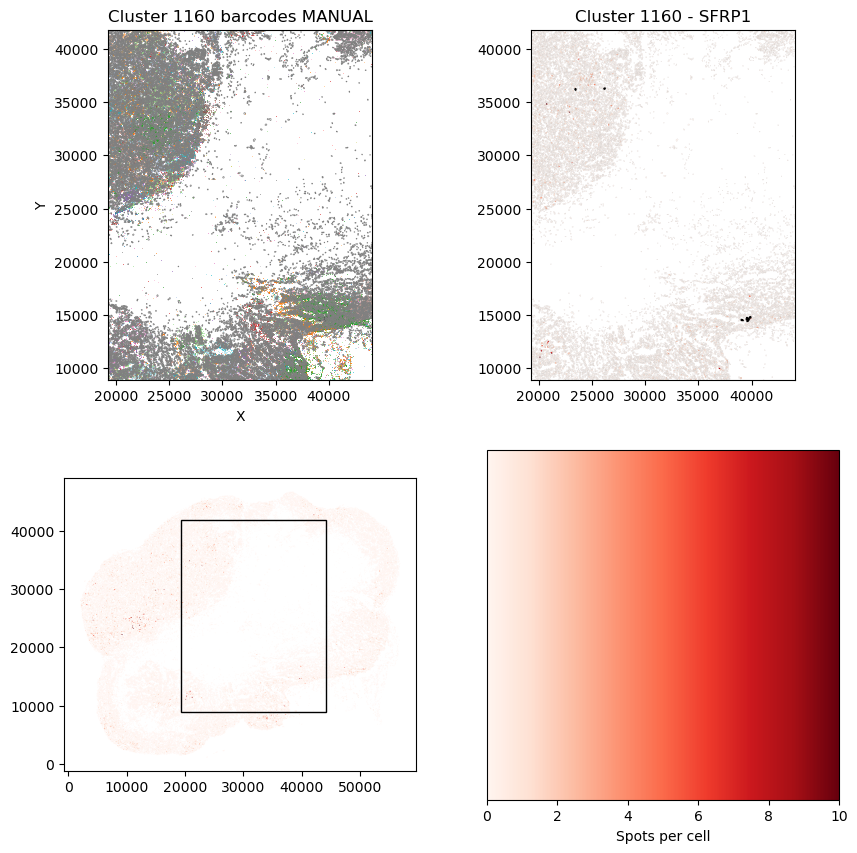

In [269]:
### plot the pattern with the cluster

gene_of_interest = 'SFRP1'
# cluster_of_interest = 31
# cluster_of_interest = 490
cluster_of_interest = 1160

# gene_of_interest = 'SPARC'
# cluster_of_interest = 2472
# cluster_of_interest = 175



cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)

# cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)

central_ix = int(len(cluster_cells)/2)

cell_id = cluster_cells[central_ix]

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

# sg_obj.gdf['object_id'] = sg_obj.gdf.index
# sg_obj.gdf['cell_id'] = sg_obj.gdf['cell_id'].astype('string')


gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')

print(np.unique(gene_names))

fig = plt.figure(figsize=(10,10))

vmin = 0
# vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])
vmax = max([df[gene_of_interest].quantile(0.99),10])

ax = fig.add_subplot(221)
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
                            #    id_field='cell_id',
                            annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
                            focal_outline_color='k',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.5,
                            exterior_marker='.',marker_size=1,ax=ax)

plt.title(f'Cluster {cluster_of_interest} barcodes MANUAL')

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

ax = fig.add_subplot(223)

merged_gdf.plot(column=gene_of_interest, cmap='Reds', legend=False,vmin=vmin,vmax=vmax,ax=ax)

rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax = fig.add_subplot(224)

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
                            norm=norm,
                            orientation='horizontal')
cb1.set_label('Spots per cell')

ax = fig.add_subplot(222)

gene_names = [gene_of_interest]

# gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

# tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
#                             annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
#                             focal_outline_color='r',other_outline_color='gray',
#                             interior_marker='.',single_mode=False,lw=0.5,
#                             exterior_marker='.',marker_size=2,ax=ax)

plt.title(f'Cluster {cluster_of_interest} - {gene_of_interest}')

# vmin = 0
# vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])
# vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),10])
print('VRange',vmin,vmax)

# other_clusters = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

bbox = box(xmin,ymin,xmax,ymax)

other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

# print(merged_gdf_focal.shape)

merged_gdf_other.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
# this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='k',linewidth=1)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.savefig(f'plots/figures/cluster_intrinsic_expression_{gene_of_interest}_{cluster_of_interest}.pdf',bbox_inches='tight')
# sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

In [40]:
# plot SFRP1 spots for the whole roi

# open spots file
spots_df = pd.read_csv(roi_file_paths[roi_of_interest]["spots_file"])



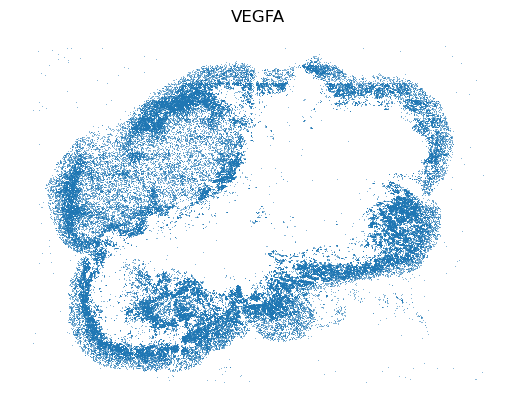

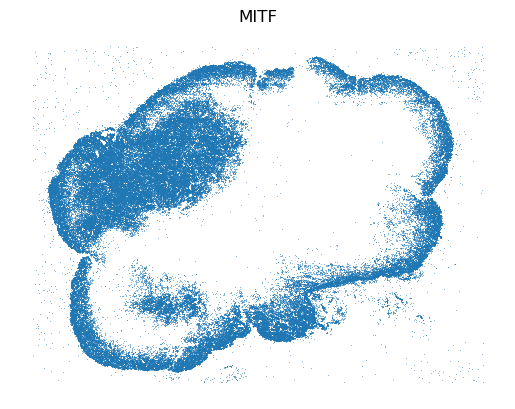

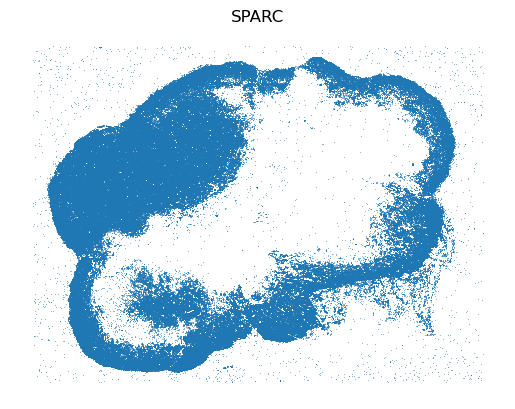

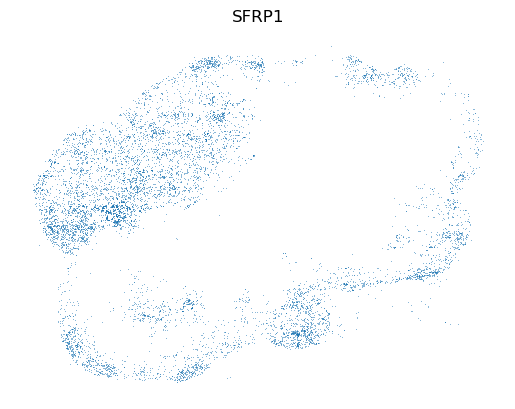

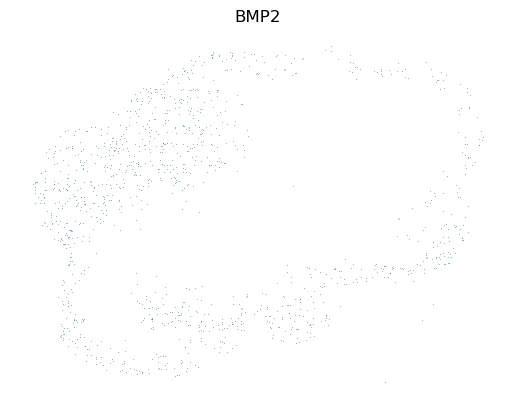

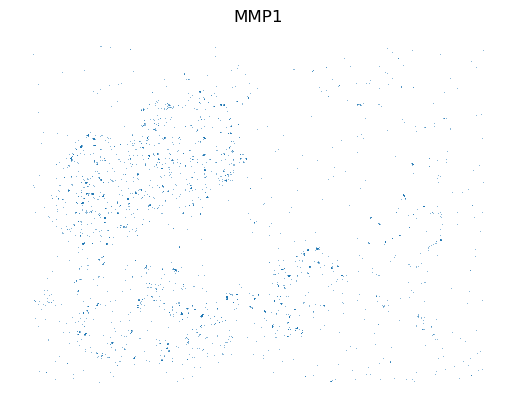

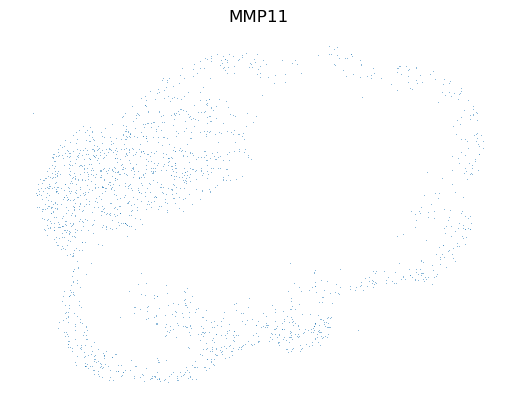

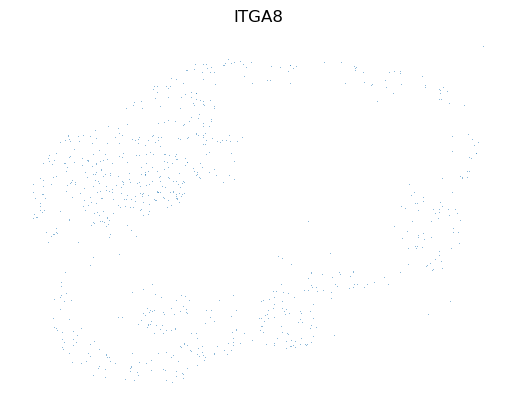

In [138]:
# plt.figure()
gene_of_interest = 'SFRP1'

gene_list = ['VEGFA',
             'MITF',
             'SPARC',
            'SFRP1',
            'BMP2',
            'MMP1',
            'MMP11',
            'ITGA8'
                ]

for gene_of_interest in gene_list:

    plt.figure()

    # get the spots for the gene of interest
    spots_gene = spots_df[spots_df['name']==gene_of_interest]

    plt.scatter(spots_gene['x'],spots_gene['y'],s=0.5,alpha=0.4,lw=0)

    # fig = plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.title(gene_of_interest)

    plt.savefig(f'plots/figures/{gene_of_interest}_spots.pdf',bbox_inches='tight')

    # turn off axes


# plt.scatter(df['center_x'],df['center_y'],c=df[gene_of_interest],cmap='Blues',s=1)

In [64]:
sns.color_palette()[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [44]:
### visualization for the paper

### plot the pattern with the cluster manually curated


# gene_of_interest = 'VCAM1'
gene_of_interest = 'SFRP1'

cluster_of_interest = 31

cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)

central_ix = int(len(cluster_cells)/2)

cell_id = cluster_cells[central_ix]

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')

print(np.unique(gene_names))

# fig = plt.figure(figsize=(10,5))

plt.title(f'Cluster {cluster_of_interest} barcodes MANUAL')

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

ax = fig.add_subplot(131)

merged_gdf.plot(column=gene_of_interest, cmap='Blues', legend=False,vmin=vmin,vmax=vmax,ax=ax)

rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax = fig.add_subplot(133)

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Blues',
                            norm=norm,
                            orientation='horizontal')
cb1.set_label('Spots per cell')

ax = fig.add_subplot(132)

gene_names = [gene_of_interest]

# gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

# tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
#                             annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
#                             focal_outline_color='r',other_outline_color='gray',
#                             interior_marker='.',single_mode=False,lw=0.5,
#                             exterior_marker='.',marker_size=2,ax=ax)

plt.title(f'Cluster {cluster_of_interest} - {gene_of_interest} MANUAL')

# vmin = 0
# vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])
# vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),10])
print('VRange',vmin,vmax)

# other_clusters = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

bbox = box(xmin,ymin,xmax,ymax)

other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

# print(merged_gdf_focal.shape)

merged_gdf_other.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

# this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.savefig(f'plots/figures/cluster_intrinsic_expression_{gene_of_interest}_{cluster_of_interest}_MANUAL_clean.pdf',bbox_inches='tight')
# sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

name               refid      x      y
0                      SOX10     ENSG00000100146  18203     53
1                      SOX10     ENSG00000100146  18260    132
2                      SOX10     ENSG00000100146  18185     77
3                      SOX10     ENSG00000100146  18434    223
4                      SOX10     ENSG00000100146  22740    204
...                      ...                 ...    ...    ...
16584996  ENSMUSG00000071361  ENSMUSG00000071361   9197  48023
16584997  ENSMUSG00000071361  ENSMUSG00000071361   9245  47972
16584998  ENSMUSG00000071361  ENSMUSG00000071361  10479  47915
16584999  ENSMUSG00000071361  ENSMUSG00000071361  42879  47872
16585000  ENSMUSG00000071361  ENSMUSG00000071361  50070  48113

[16585001 rows x 4 columns]

In [ ]:
### 

n_bcs_per_cluster_cutoff = 3
# n_cells_per_cluster_cutoff = 5
n_cells_per_cluster_cutoff = 10

# using the clustering to call clones
confident_clusters = adata_genes[adata_genes.obs['bc_cluster_n_bcs'] >= n_bcs_per_cluster_cutoff]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)
sns.histplot(cluster_sizes)
plt.axvline(n_cells_per_cluster_cutoff,color='r')
plt.xscale('log')

# large enough clusters
large_clusters = cluster_names[cluster_sizes >= n_cells_per_cluster_cutoff]

confident_clusters = adata_genes[adata_genes.obs['bc_cluster'].isin(large_clusters)]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)
# sns.histplot(cluster_sizes)


<AxesSubplot: xlabel='SFRP1', ylabel='Density'>

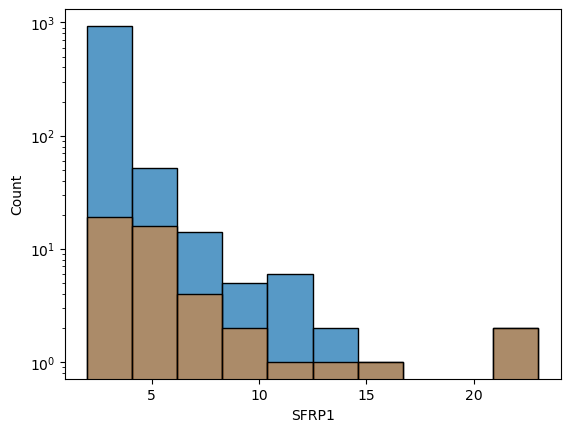

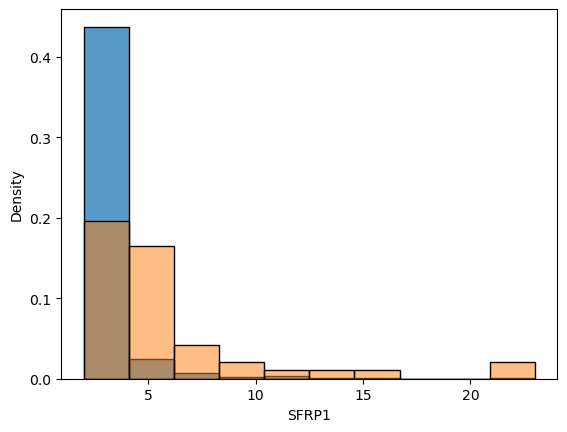

In [140]:
counts,bins = np.histogram(df[df['SFRP1']>1]['SFRP1'])

sns.histplot(df['SFRP1'],bins=bins)
sns.histplot(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],bins=bins,alpha=0.5)
plt.yscale('log')

plt.figure()

non_zero_cells = df[df['SFRP1']>1]
# counts,bins = np.histogram(non_zero_cells['SFRP1'])



sns.histplot(non_zero_cells['SFRP1'],bins=bins,stat='density')
sns.histplot(non_zero_cells[non_zero_cells['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],bins=bins,alpha=0.5,stat='density')
# plt.yscale('log')

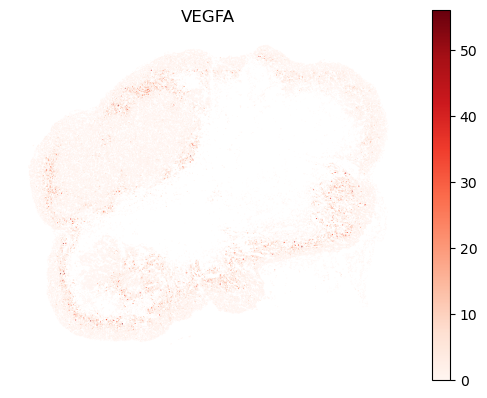

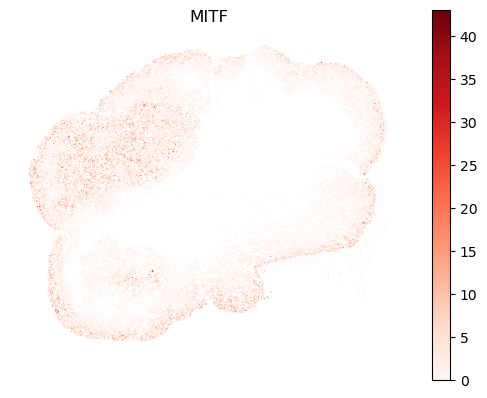

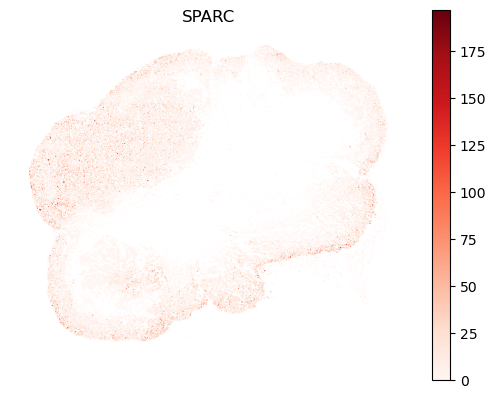

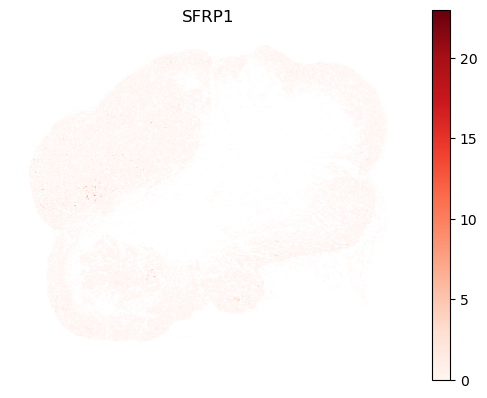

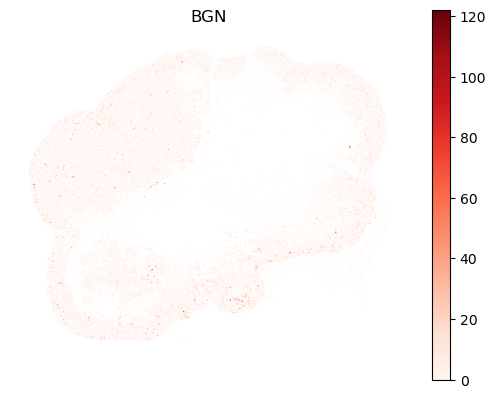

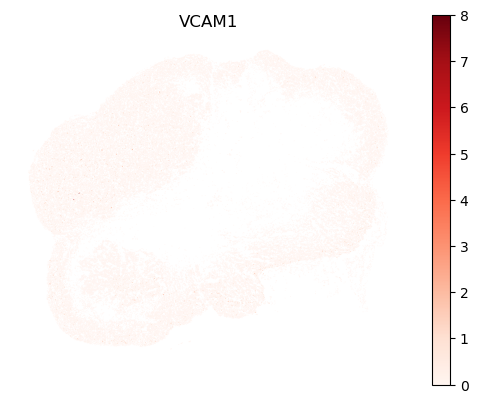

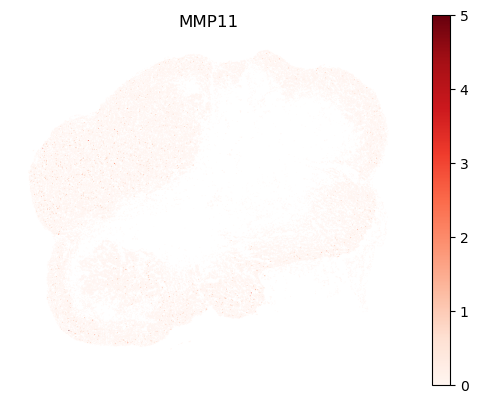

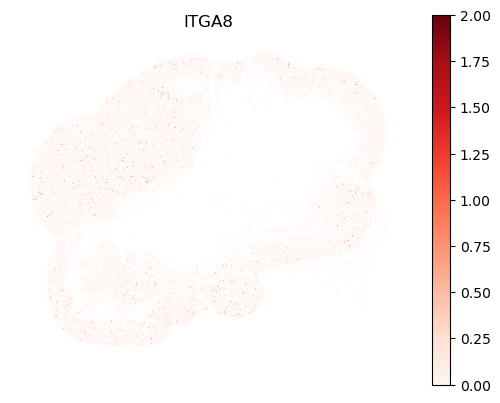

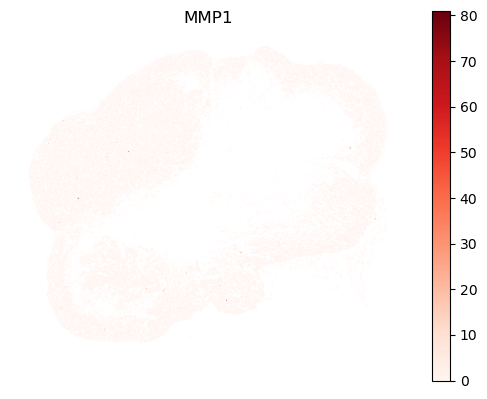

In [ ]:
for gene in genes_to_show:
    # plt.text(ex_in_entropy.loc[gene,'intrinsic_z'],ex_in_entropy.loc[gene,'extrinsic_z'],gene)    
    # fig,ax = plt.subplots()
    fig = plt.figure()
    ax = plt.gca()
    # ax.set_facecolor('g')

    plt.title(gene)
    sg_obj.gdf.plot(column=gene,cmap='Reds',ax=ax,legend=True,facecolor='gray')
    # ax.set_facecolor('gray')
    plt.axis('off')

cell_id  n_called_barcodes barcode_names called_barcodes  object_id  \
0           1                  0           NaN              []          1   
1           2                  0           NaN              []          2   
2           3                  1        bc_060      ['bc_060']          3   
3           4                  0           NaN              []          4   
4           7                  0           NaN              []          7   
...       ...                ...           ...             ...        ...   
67197   67193                  0           NaN              []      67193   
67198   67199                  0           NaN              []      67199   
67199   67200                  0           NaN              []      67200   
67200   67201                  0           NaN              []      67201   
67201   67202                  0           NaN              []      67202   

       bc_cluster  bc_cluster_n_bcs bc_cluster_found_bcs bc_cluster_bc_names  
0             NaN               NaN                  NaN                 NaN  
1             NaN               NaN                  NaN                 NaN  
2             NaN               NaN                  NaN                 NaN  
3             NaN               NaN                  NaN                 NaN  
4             NaN               NaN                  NaN                 NaN  
...           ...               ...                  ...                 ...  
67197         NaN               NaN                  NaN                 NaN  
67198         NaN               NaN                  NaN                 NaN  
67199         NaN               NaN                  NaN                 NaN  
67200         NaN               NaN                  NaN                 NaN  
67201         NaN               NaN                  NaN                 NaN  

[67202 rows x 9 columns]

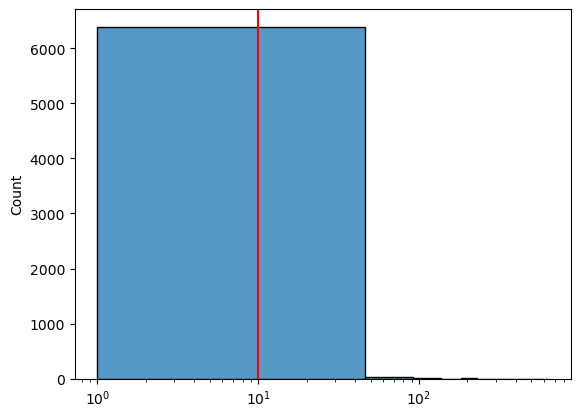

In [ ]:
## what if we don't use the clustering? how does this change the results?

n_bcs_per_cluster_cutoff = 3
# n_cells_per_cluster_cutoff = 5
n_cells_per_cluster_cutoff = 10

# using the clustering to call clones
confident_clusters_unclustered = adata_genes[adata_genes.obs['n_called_barcodes'] >= n_bcs_per_cluster_cutoff]

cluster_names, cluster_sizes = np.unique(confident_clusters_unclustered.obs['barcode_names'],return_counts=True)
sns.histplot(cluster_sizes)
plt.axvline(n_cells_per_cluster_cutoff,color='r')
plt.xscale('log')

# large enough clusters
large_clusters = cluster_names[cluster_sizes >= n_cells_per_cluster_cutoff]

confident_clusters_unclustered = adata_genes[adata_genes.obs['barcode_names'].isin(large_clusters)]

cluster_names, cluster_sizes = np.unique(confident_clusters_unclustered.obs['barcode_names'],return_counts=True)
# sns.histplot(cluster_sizes)


In [ ]:
# calculate the statistics for clones
real_delta_unclustered  = group_delta_mean(confident_clusters_unclustered,'barcode_names')
perm_deltas_unclustered = permuted_group_delta_means(confident_clusters_unclustered,'barcode_names',n_perms=1000)

# calculate the scores and p-values for the clones
scores_unclustered = calculate_group_scores(real_delta_unclustered,pd.DataFrame(perm_deltas_unclustered))
p_vals_unclustered = calculate_empirical_p_values(real_delta_unclustered,pd.DataFrame(perm_deltas_unclustered))

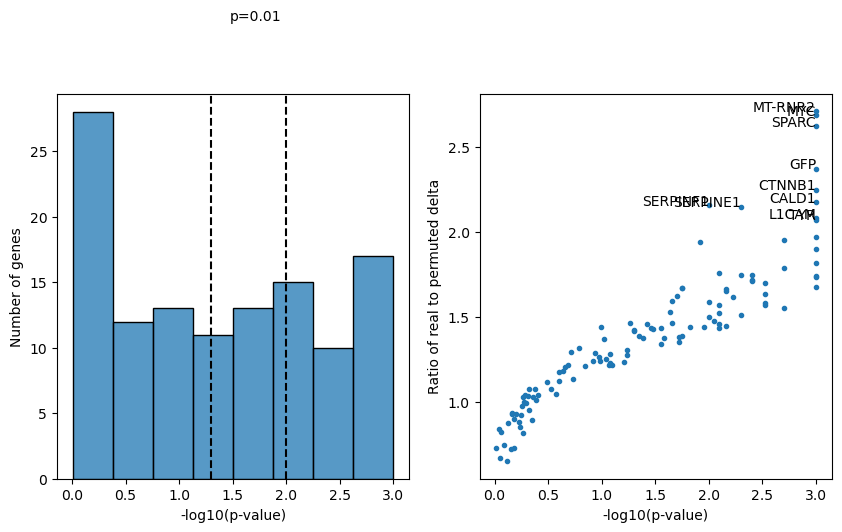

In [ ]:
# plot clone scores and p-values

plt.figure(figsize=(10,5))

## subplot 
plt.subplot(1,2,1)
sns.histplot(-np.log10(p_vals_unclustered))

plt.axvline(-np.log10(0.01),color='k',linestyle='--')
plt.text(-np.log10(0.01+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.05),color='k',linestyle='--')
# plt.axvline(-np.log10(0.1),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Number of genes')

# calculate ratio of real data to average from the permutations
plt.subplot(1,2,2)
plt.scatter(-np.log10(p_vals_unclustered),scores_unclustered,marker='.')

plt.xlabel('-log10(p-value)')
plt.ylabel('Ratio of real to permuted delta')

# annotate top genes
for gene in scores_unclustered.sort_values(ascending=False)[:10].index:
    plt.text(-np.log10(p_vals_unclustered[gene]),scores_unclustered[gene],gene,ha='right')

In [39]:
sg_obj.gdf

object_id                                            nucleus  \
0             1  POLYGON ((23727.000 1097.000, 23741.000 1098.0...   
1            10  POLYGON ((19439.000 1568.000, 19452.000 1569.0...   
2           100  POLYGON ((20345.000 1807.000, 20355.000 1818.0...   
3          1000  POLYGON ((10876.000 2957.000, 10910.000 2999.0...   
4         10000  POLYGON ((34221.000 9631.000, 34230.000 9631.0...   
...         ...                                                ...   
67197      9995  POLYGON ((24154.000 9628.000, 24163.000 9628.0...   
67198      9996  POLYGON ((5129.000 9629.000, 5144.000 9639.000...   
67199      9997  POLYGON ((10140.000 9629.000, 10161.000 9631.0...   
67200      9998  POLYGON ((13878.000 9629.000, 13901.000 9632.0...   
67201      9999  POLYGON ((17093.000 9630.000, 17104.000 9632.0...   

                                         nucleus_dilated cell_id  AKT1  AXL  \
0      POLYGON ((23723.193 1087.753, 23706.193 1094.7...       1   0.0  0.0   
1      POLYGON ((19435.376 1558.680, 19417.376 1565.6...      10   1.0  0.0   
2      POLYGON ((20339.700 1798.520, 20333.649 1802.3...     100   0.0  0.0   
3      POLYGON ((10866.161 2955.211, 10864.921 2962.0...    1000   5.0  0.0   
4      POLYGON ((34216.771 9621.938, 34201.771 9628.9...   10000   0.0  0.0   
...                                                  ...     ...   ...  ...   
67197  POLYGON ((24146.000 9622.000, 24140.000 9630.0...    9995   0.0  0.0   
67198  POLYGON ((5121.929 9621.929, 5120.807 9623.051...    9996   2.0  0.0   
67199  POLYGON ((10135.862 9619.896, 10124.862 9624.8...    9997   0.0  0.0   
67200  POLYGON ((13871.753 9621.191, 13866.753 9625.1...    9998   0.0  0.0   
67201  POLYGON ((17089.286 9620.715, 17074.286 9626.7...    9999   0.0  0.0   

       BGN  BIRC3  BIRC5  BMP2  ...  bc_096  bc_cluster  bc_cluster_bc_names  \
0      0.0    0.0    0.0   0.0  ...     0.0         NaN                  NaN   
1      0.0    0.0    1.0   0.0  ...     0.0         NaN                  NaN   
2      1.0    0.0    0.0   0.0  ...     0.0         NaN                  NaN   
3      0.0    0.0    1.0   0.0  ...     0.0       454.0        bc_068-bc_086   
4      0.0    0.0    1.0   0.0  ...     0.0       615.0        bc_004-bc_033   
...    ...    ...    ...   ...  ...     ...         ...                  ...   
67197  0.0    0.0    0.0   0.0  ...     0.0         NaN                  NaN   
67198  0.0    0.0    0.0   0.0  ...     0.0      2722.0        bc_005-bc_030   
67199  0.0    0.0    0.0   0.0  ...     0.0         NaN                  NaN   
67200  0.0    0.0    0.0   0.0  ...     0.0         NaN                  NaN   
67201  0.0    0.0    0.0   0.0  ...     1.0         NaN                  NaN   

       bc_cluster_found_bcs  bc_cluster_n_bcs       called_barcodes  \
0                       NaN               NaN                    []   
1                       NaN               NaN  ['bc_013', 'bc_060']   
2                       NaN               NaN                    []   
3      ['bc_068', 'bc_086']               2.0  ['bc_068', 'bc_086']   
4      ['bc_004', 'bc_033']               2.0  ['bc_004', 'bc_033']   
...                     ...               ...                   ...   
67197                   NaN               NaN                    []   
67198  ['bc_005', 'bc_030']               2.0  ['bc_005', 'bc_030']   
67199                   NaN               NaN                    []   
67200                   NaN               NaN                    []   
67201                   NaN               NaN            ['bc_045']   

           center_x     center_y  n_called_barcodes  \
0      23747.879606  1155.889230                  0   
1      19439.586687  1590.118851                  2   
2      20308.017937  1845.078634                  0   
3      10900.868011  3028.338325                  2   
4      34222.068445  9672.302458                  2   
...             ...          ...                ...   
67197  24164.8041